In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import expm, eigh
%matplotlib widget

# Define energy levels (in eV)
energy_levels = {
    '1s': -24.6,
    '1s2p': -3.4,
    's': 17.8,
    'p': 17.8,
    'd': 17.8
}

# Atomic Unit Conversion
au_time = 2.4188843265864e-2 # fs
hartree_energy = 27.211386245981 # eV
au_time_conversion = 1 / au_time # from fs to au_time
au_energy_conversion = 1 / hartree_energy # from eV to au_energy

# Energies and dipole elements
omega_s_eV = energy_levels['1s']
omega_p_eV = energy_levels['1s2p']
omega_es_eV = energy_levels['s']
omega_ep_eV = energy_levels['p']
omega_ed_eV = energy_levels['d']

# Convert energies from eV to atomic units
omega_s = omega_s_eV * au_energy_conversion
omega_p = omega_p_eV * au_energy_conversion
omega_es = omega_es_eV * au_energy_conversion
omega_ep = omega_ep_eV * au_energy_conversion
omega_ed = omega_ed_eV * au_energy_conversion

d_sp  = 0.45
d_pes, d_sep, d_ped = 0.0015, 0.00015, 0.001

# Time array(in fs)
start_time, stop_time = -200,200  # fs
steps = 100000  # steps
t_values_SI = np.linspace(start_time, stop_time, steps)  # Time array in femtoseconds
dt_SI = t_values_SI[1]- t_values_SI[0]
print(f'Time Step is {np.round(dt_SI*1000, decimals =2)} attoseconds')
t_values = t_values_SI *au_time_conversion  # Time array in atomic units
# Time step
dt = t_values[1] - t_values[0]
# Electric Field parameters
phi1 = 0.0
phi2 = 0.0
#phi2 = np.pi/2
tau = 50  # fs
E0_au = 0.00005
E02_au = 0.000005
t0 = 0 # fs  # setting t0 to a non-zero value to avoid zero limit issue
tau_au = tau * au_time_conversion
t0_au = t0 * au_time_conversion
omega_au = 21.2 * au_energy_conversion
# Markers and annotations
t_min = -(tau-5)*au_time_conversion*3
t_max = (tau-5)*au_time_conversion*3
delta_T = dt*1000


Time Step is 4.0 attoseconds


In [9]:
# Electric field functions
def E_omega(t):
    return E0_au * np.exp(-((t - t0_au) / tau_au) ** 2) * (np.cos(omega_au * t + phi1)**2)


def E_2omega(t):
    return E02_au * np.exp(-((t - t0_au) / tau_au) ** 2) * (np.cos(2*omega_au * t + phi2)**2)


# Initial Hamiltonian without the field
H0 = np.array([
    [omega_s, 0, 0, 0, 0],
    [0, omega_p, 0, 0, 0],
    [0, 0, omega_es, 0, 0],
    [0, 0, 0, omega_ep, 0],
    [0, 0, 0, 0, omega_ed]
], dtype=complex)

# Define the decay term in atomic units
decay = au_energy_conversion*1j
H0[2, 2] -= decay  # omega_es
H0[3, 3] -= decay  # omega_ep
H0[4, 4] -= decay  # omega_ed

print(H0)

# Hamiltonian function
def hamiltonian(t):
    E_om = E_omega(t)
    E_2om = E_2omega(t)
    return np.array([
        [0, d_sp * E_om, 0, d_sep * E_2om, 0],
        [d_sp * E_om, 0, d_pes * E_om, 0, d_ped * E_om],
        [0, d_pes * E_om, 0, 0, 0],
        [d_sep * E_2om, 0, 0, 0, 0],
        [0, d_ped * E_om, 0, 0, 0]
    ], dtype=complex)


[[-0.90403333+0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j         -0.1249477 +0.j          0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.65413793-0.03674932j
   0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.65413793-0.03674932j  0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.65413793-0.03674932j]]


In [10]:
# Initial state
psi_0 = np.array([1, 0, 0, 0, 0], dtype=complex)
psi_t_list = [psi_0]

U0_half_dt = expm(-1j * H0 * dt / 2)
for index in range(len(t_values)-1):
    #Prepare the initial conditions for the current time step
    t = t_values[index] # Get the current time
    #print(f'time is {t} for index {index}')
    Hamil_t = hamiltonian(t) # Get the Hamiltonian at the current time
    #print(f'Hamil_t: {Hamil_t}')
    # Diagonalize the Hamiltonian
    eigenvalues, eigenvectors = eigh(Hamil_t)
    # Check if the eigenvectors are unitary(Unitary if UU^dagger = I)
    assert np.allclose(Hamil_t, Hamil_t.T.conj()), "Hamiltonian is not Hermitian"
    assert np.allclose(np.dot(eigenvectors.T.conj(), eigenvectors), np.eye(len(Hamil_t))), "Eigenvectors are not unitary"

    # Start of spil-operators method
    psi_dt = psi_t_list[index] # Get the wave function at the current time
    #print(f'psi_dt: {psi_dt}')
    psi_0_U0 = np.dot(U0_half_dt, psi_dt) # Step 0: Apply U0_half_dt to the wave function

    psi_0_eigenbasis = np.dot(eigenvectors.T.conj(), psi_0_U0) # Step 1: Transform the initial wave function to the eigenbasis
    #print(f'psi_0_eigenbasis: {psi_0_eigenbasis}')
    U_t = np.diag(np.exp(-1j * eigenvalues * dt ))
    #print(f'U_t: {U_t}')
    psi_t_eigenbasis = np.dot(U_t, psi_0_eigenbasis) # Step 2: Apply the diagonal matrix to the wave function in the eigenbasis
    #print(f'psi_t_eigenbasis: {psi_t_eigenbasis}')

    # Transform back to the original basis
    psi_t_pre = np.dot(eigenvectors, psi_t_eigenbasis) # Step 3: Transform the wave function back to the original basis
    #print(f'psi_t_pre: {psi_t_pre}')
    psi_t_U0 = np.dot(U0_half_dt, psi_t_pre) # Step 4: Apply U0_half_dt to the wave function
    #print(f'psi_t_U0: {psi_t_U0}')
    psi_t_list.append(psi_t_U0)  # Store the result
#print(f'psi_t_list: {psi_t_list}')

# Convert the list to a NumPy array for further processing
psi_t_array = np.array(psi_t_list)

df_psi = pd.DataFrame(psi_t_array, columns=['s', 'p', 'es', 'ep', 'ed'])
df_psi.to_csv(f'psi_t_{omega_eV}.csv', index=False)

prob_s = np.abs(np.array(psi_t_array)[:,0])**2
prob_p = np.abs(np.array(psi_t_array)[:, 1])**2
prob_es = np.abs(np.array(psi_t_array)[:, 2])**2
prob_ep = np.abs(np.array(psi_t_array)[:, 3])**2
prob_ed = np.abs(np.array(psi_t_array)[:, 4])**2

title = f"State probabilities over time for {omega_eV} with E_omega = {E0_au}au and E_2omega = {E02_au}"
plt.figure(figsize=(10, 6))
plt.plot(t_values_SI, prob_s, label='Probability in s state')
plt.plot(t_values_SI, prob_p, label='Probability in p state')
plt.plot(t_values_SI, prob_es, label='Probability in es state')
plt.plot(t_values_SI, prob_ep, label='Probability in ep state')
plt.plot(t_values_SI, prob_ed, label='Probability in ed state')
plt.title(title)
plt.xlabel('Time (atomic units)')
plt.ylabel('Probability')
plt.grid(which='both')

plt.legend()
#plt.savefig(f"{title}.png")
plt.show()

NameError: name 'omega_eV' is not defined

In [ ]:
title = f"State probabilities over time for {omega_eV} with E_omega = {E0_au}au and E_2omega = {E02_au}"
plt.figure(figsize=(10, 6))
#plt.plot(t_values_SI, prob_s, label='Probability in s state')
#plt.plot(t_values_SI, prob_p, label='Probability in p state')
plt.plot(t_values_SI, prob_es, label='Probability in es state')
plt.plot(t_values_SI, prob_ep, label='Probability in ep state')
plt.plot(t_values_SI, prob_ed, label='Probability in ed state')
plt.title(title)
plt.xlabel('Time (atomic units)')
plt.ylabel('Probability')
plt.grid(which='both')

plt.legend()
#plt.savefig(f"{title}.png")
plt.show()

In [ ]:

def C_t(t, t_min, t_max, delta_T):
    return np.where(
        t < t_min - delta_T, 0,
        np.where(t < t_min, np.sin((t - (t_min - delta_T)) * (np.pi / (2 * delta_T))) ** 2,
        np.where(t <= t_max, 1,
        np.where(t <= t_max + delta_T, np.cos((t - t_max) * (np.pi / (2 * delta_T))) ** 2, 0))))

# Function for E_omega (fundamental frequency)
def E_omega(t, E0, omega, t0, tau, phi, t_min, t_max, delta_T):
    envelope = np.exp(-((t - t0) / tau) ** 2)
    oscillation = np.cos(omega * t + phi)
    return E0 * envelope * oscillation * C_t(t, t_min, t_max, delta_T)

# Function for E_2omega (second harmonic)
def E_2omega(t, E02, omega, t0, tau, phi, t_min, t_max, delta_T):
    envelope = np.exp(-((t - t0) / tau) ** 2)
    oscillation = np.cos(2 * omega * t + phi)  # Second harmonic = 2 * omega
    return E02 * envelope * oscillation * C_t(t, t_min, t_max, delta_T)

# Initial Hamiltonian without the field
H0 = np.array([
    [omega_s, 0, 0, 0, 0],
    [0, omega_p, 0, 0, 0],
    [0, 0, omega_es, 0, 0],
    [0, 0, 0, omega_ep, 0],
    [0, 0, 0, 0, omega_ed]
], dtype=complex)


# Define the decay term in atomic units
decay = au_energy_conversion*1j  #1 eV decay
H0[2, 2] -= decay  # omega_es
H0[3, 3] -= decay  # omega_ep
H0[4, 4] -= decay  # omega_ed

# Hamiltonian function
def hamiltonian(t,omega, d_ped, d_pes, d_sep, d_sp):
    #print(t)
    E_om = E_omega(t, E0_au, omega, t0_au, tau_au, phi1, t_min, t_max, delta_T)
    #print(E_om)
    E_2om = E_2omega(t, E02_au, omega, t0_au, tau_au, phi2, t_min, t_max, delta_T)
    #print(E_2om)
    return np.array([
        [0, d_sp * E_om, 0, d_sep * E_2om, 0],
        [d_sp * E_om, 0, d_pes * E_om, 0, d_ped * E_om],
        [0, d_pes * E_om, 0, 0, 0],
        [d_sep * E_2om, 0, 0, 0, 0],
        [0, d_ped * E_om, 0, 0, 0]
    ], dtype=complex)

In [18]:




def tdse_solver(omega_ev):
    global omega_au
    omega_au = omega_ev*au_energy_conversion
    #H0_au = H0(omega_s, omega_p, omega_es, omega_ep, omega_ed)
    H0_au = H0
    U0_half_dt = expm(-1j * H0_au * dt / 2)

    #print(f"Omega: {omega_au}")
    dfs = {} # DataFrames for the all the populations at each time step
    dfp = {} # DataFrames for the all the populations at final time step
    # Initial state
    psi_0 = np.array([1, 0, 0, 0, 0], dtype=complex)
    psi_t_list = [psi_0]
    psi_pop = []
    
    for index in range(len(t_values)-1):
        t = t_values[index] 
        #hamil_t = hamiltonian(t, omega_au, d_ped, d_pes, d_sep, d_sp)
        hamil_t = hamiltonian(t)
        eigenvalues, eigenvectors = eigh(hamil_t)
        assert np.allclose(hamil_t, hamil_t.T.conj()), "Hamiltonian is not Hermitian"
        assert np.allclose(np.dot(eigenvectors.T.conj(), eigenvectors), np.eye(len(hamil_t))), "Eigenvectors are not unitary"
        psi_dt = psi_t_list[index]
        psi_0_u0 = np.dot(U0_half_dt, psi_dt)
        psi_0_eigenbasis = np.dot(eigenvectors.T.conj(), psi_0_u0)
        u_t = np.diag(np.exp(-1j * eigenvalues * dt ))
        psi_t_eigenbasis = np.dot(u_t, psi_0_eigenbasis)
        psi_t_pre = np.dot(eigenvectors, psi_t_eigenbasis)
        psi_t_u0 = np.dot(U0_half_dt, psi_t_pre)
        psi_t_list.append(psi_t_u0)
        psi_pop.append(np.abs(psi_t_u0)**2)
        #print(np.abs(psi_t_U0))
    psi_t_array = np.array(psi_t_list)
    dfs[f'df_psi_{round(omega_ev,4)}'] = pd.DataFrame(psi_t_array, columns=['s', 'p', 'es', 'ep', 'ed'])

    psi_pop_array = np.array(psi_pop)
    dfp[f'df_pop_{round(omega_ev,4)}'] = pd.DataFrame(psi_pop_array, columns=['s', 'p', 'es', 'ep', 'ed'])
    return dfs, dfp

In [19]:
omega_ev = 21.2
dfs1, dfp1 = tdse_solver(omega_ev)

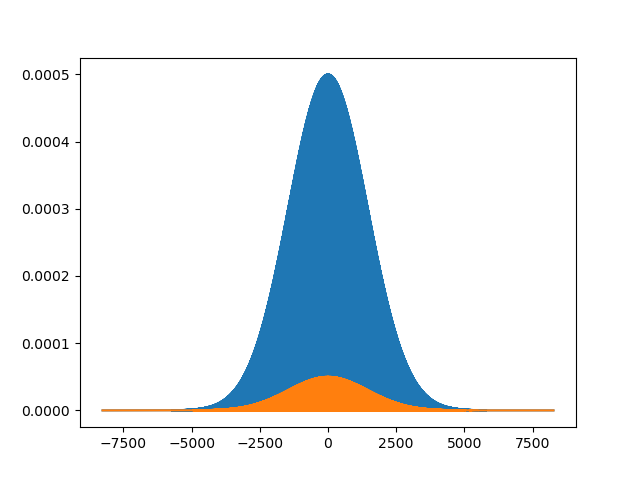

In [21]:
# Electric Field parameters
phi1 = 0.0
phi2 = 0.0
tau = 50  # fs
tau_au = tau * 41
t0 = 0 # fs  # setting t0 to a non-zero value to avoid zero limit issue
t0_au = t0 * 41
E0_au = 0.0005
E02_au = 0.00005
omega = 21.2/27.2
t_min = -(tau-5)*41*3
t_max = (tau-5)*41*3
delta_T = dt*10
#E_om = E_omega(t_values, E0_au, omega, t0_au, tau_au, phi1, t_min, t_max, delta_T)
E_om = E_omega(t_values)
E_2om = E_2omega(t_values)
#E_2om = E_2omega(t_values, E02_au, omega, t0_au, tau_au, phi2, t_min, t_max, delta_T)
plt.figure()
plt.plot(t_values, E_om)
plt.plot(t_values, E_2om)
plt.show()

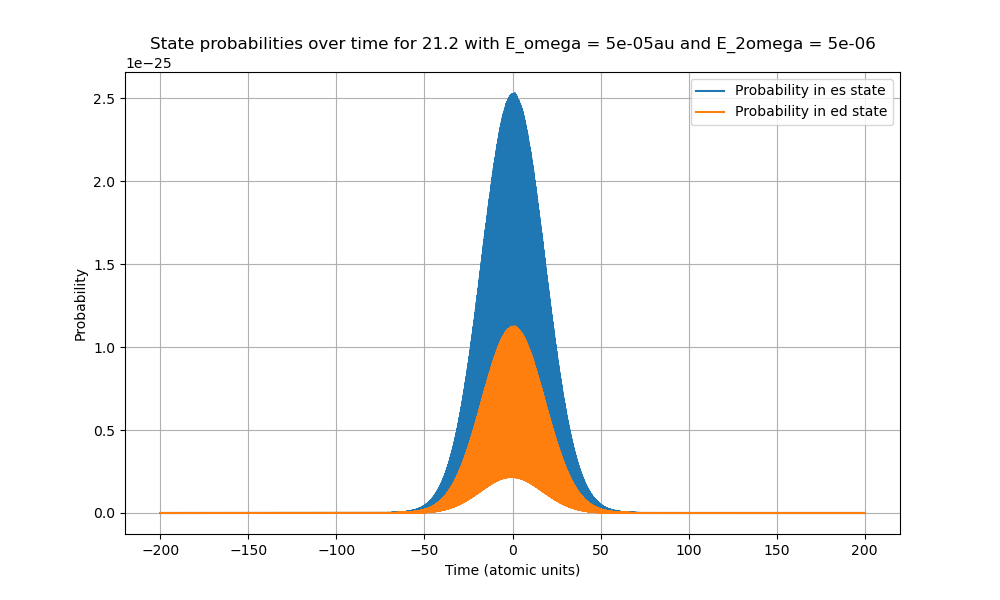

In [20]:
prob_s = np.abs(np.array(dfs1['df_psi_21.2']['s']))**2
prob_p = np.abs(np.array(dfs1['df_psi_21.2']['p']))**2
prob_es = np.abs(np.array(dfs1['df_psi_21.2']['es']))**2
prob_ep = np.abs(np.array(dfs1['df_psi_21.2']['ep']))**2
prob_ed = np.abs(np.array(dfs1['df_psi_21.2']['ed']))**2

title = f"State probabilities over time for {omega_ev} with E_omega = {E0_au}au and E_2omega = {E02_au}"
plt.figure(figsize=(10, 6))
#plt.plot(t_values_SI, prob_s, label='Probability in s state')
#plt.plot(t_values_SI, prob_p, label='Probability in p state')
plt.plot(t_values_SI, prob_es, label='Probability in es state')
#plt.plot(t_values_SI, prob_ep, label='Probability in ep state')
plt.plot(t_values_SI, prob_ed, label='Probability in ed state')
plt.title(title)
plt.xlabel('Time (atomic units)')
plt.ylabel('Probability')
plt.grid(which='both')

plt.legend()
#plt.savefig(f"{title}.png")
plt.show()


In [16]:
Hint_T = []
for index in range(len(t_values)-1):
    t = t_values[index] 
    hamil_t = hamiltonian(t, omega_au, d_ped, d_pes, d_sep, d_sp)
    Hint_T.append(hamil_t)

In [22]:
Hint_T2 = []
for index in range(len(t_values)-1):
    t = t_values[index] 
    hamil_t = hamiltonian(t)
    Hint_T2.append(hamil_t)

In [23]:
Hint_T2[17000]

array([[0.00000000e+00+0.j, 7.73746617e-09+0.j, 0.00000000e+00+0.j,
        5.07922762e-14+0.j, 0.00000000e+00+0.j],
       [7.73746617e-09+0.j, 0.00000000e+00+0.j, 2.57915539e-11+0.j,
        0.00000000e+00+0.j, 1.71943693e-11+0.j],
       [0.00000000e+00+0.j, 2.57915539e-11+0.j, 0.00000000e+00+0.j,
        0.00000000e+00+0.j, 0.00000000e+00+0.j],
       [5.07922762e-14+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j,
        0.00000000e+00+0.j, 0.00000000e+00+0.j],
       [0.00000000e+00+0.j, 1.71943693e-11+0.j, 0.00000000e+00+0.j,
        0.00000000e+00+0.j, 0.00000000e+00+0.j]])

In [17]:
Hint_T[17000]

array([[ 0.00000000e+00+0.j, -1.27931303e-08+0.j,  0.00000000e+00+0.j,
        -1.89241182e-13+0.j,  0.00000000e+00+0.j],
       [-1.27931303e-08+0.j,  0.00000000e+00+0.j, -4.26437677e-11+0.j,
         0.00000000e+00+0.j, -2.84291784e-11+0.j],
       [ 0.00000000e+00+0.j, -4.26437677e-11+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j],
       [-1.89241182e-13+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j],
       [ 0.00000000e+00+0.j, -2.84291784e-11+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j]])

Compare with C.Green Theory

In [77]:
data=np.loadtxt('c_phi_spd_40_45 (no phase jumps).dat',skiprows=1)
data[1294:2874,2]=-data[1294:2874,2]
data[1294:1564,6]=-data[1294:1564,6]

In [78]:
Ew= E0_au
E2w= E02_au

DeltaPhi=0

omega=data[:,1]/2
c0=data[:,2]*Ew**2
c1=data[:,4]*E2w
c2=data[:,6]*Ew**2
phi0=data[:,3]
phi1=data[:,5]
phi2=data[:,7]

Wtot=c0**2 + c1**2 + c2**2
beta1=(2*np.sqrt(3)*c0*c1*np.cos(DeltaPhi-(phi0-phi1))
      +(4/np.sqrt(3))*c1*c2*np.cos(DeltaPhi-(phi2-phi1)))/Wtot
beta2=(2*c1**2 + (10/7)*c2**2 + 2*np.sqrt(5)*c0*c2*np.cos(phi2-phi0))/Wtot
beta3=((6/np.sqrt(3))*c1*c2*np.cos(DeltaPhi-(phi2-phi1)))/Wtot
beta4=((18/7)*c2**2)/Wtot

Ecooper=(-c2[1563]/(c2[1564]-c2[1563]))*(omega[1564]-omega[1563])+omega[1563]
Eres=21.216174

In [79]:
%matplotlib widget

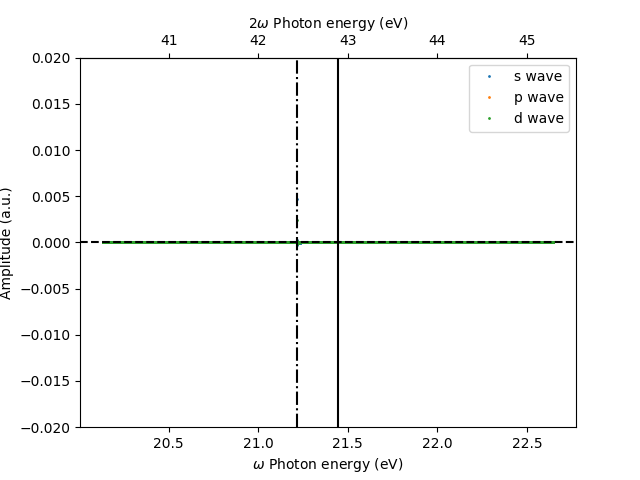

In [80]:
fig,ax = plt.subplots()
ax.plot(omega,c0,'.',label='s wave',markersize=2)
ax.plot(omega,c1,'.',label='p wave',markersize=2)
ax.plot(omega,c2,'.',label='d wave',markersize=2)
ax.axvline(x=Ecooper,color='black')
ax.axvline(x=Eres,color='black',ls='dashdot')
ax.axhline(y=0,color='black',ls='--')
#plt.yscale('symlog')
ax.set_xlabel(r'$\omega$ Photon energy (eV)')
ax.set_ylabel('Amplitude (a.u.)')
#ax.set_xlim(21.2161,21.2162)
ax.set_ylim(-0.02,0.02)
plt.legend()
ax2=ax.secondary_xaxis('top',functions=(lambda x:x*2, lambda x:x/2))
ax2.set_xlabel(r'2$\omega$ Photon energy (eV)')
plt.show()
#plt.close()